In [1]:
#Import all packages needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import tweepy 
import json

## Gather
1- The WeRateDogs Twitter archive. Download this file manually by clicking the following link: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv

In [2]:
twitter_archive_enhancediter = pd.read_csv('twitter-archive-enhanced.csv')

2- The tweet image predictions, should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

In [ ]:
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

with open('image-predictions.tsv', mode ='wb') as file:
    file.write(response.content)

#Read TSV file
image_prediction = pd.read_csv('image-predictions.tsv', sep='\t' )

In [3]:
#Read TSV file
image_prediction = pd.read_csv('image-predictions.tsv', sep='\t' )

3- Each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count.

In [4]:

auth = tweepy.OAuthHandler('', '')
auth.set_access_token('', '')
api = tweepy.API(auth, 
                 parser = tweepy.parsers.JSONParser(), 
                 wait_on_rate_limit = True, 
                 wait_on_rate_limit_notify = True)

In [ ]:

#Download Tweepy status object based on Tweet ID and store in list
list_of_tweets = []
# Tweets that can't be found are saved in the list below:
cant_find_tweets_for_those_ids = []
for tweet_id in twitter_archive_enhancediter['tweet_id']:   
    try:
        list_of_tweets.append(api.get_status(tweet_id))
    except Exception as e:
        cant_find_tweets_for_those_ids.append(tweet_id)

In [ ]:
print("The list of tweets" ,len(list_of_tweets))
print("The list of tweets no found" , len(cant_find_tweets_for_those_ids))

In [ ]:

my_list_of_dicts = []
for each_json_tweet in list_of_tweets:
    my_list_of_dicts.append(each_json_tweet)

In [ ]:

#we write this list into a txt file:

with open('tweet_json.txt', 'w') as file:
        file.write(json.dumps(my_list_of_dicts, indent=4))

In [5]:
#identify information of interest from JSON dictionaries in txt file
#and put it in a dataframe called tweet JSON
my_demo_list = []
with open('tweet_json.txt', encoding='utf-8') as json_file:  
    all_data = json.load(json_file)
    for each_dictionary in all_data:
        tweet_id = each_dictionary['id']
        whole_tweet = each_dictionary['text']
        only_url = whole_tweet[whole_tweet.find('https'):]
        favorite_count = each_dictionary['favorite_count']
        retweet_count = each_dictionary['retweet_count']
        followers_count = each_dictionary['user']['followers_count']
        friends_count = each_dictionary['user']['friends_count']
        whole_source = each_dictionary['source']
        only_device = whole_source[whole_source.find('rel="nofollow">') + 15:-4]
        source = only_device
        retweeted_status = each_dictionary['retweeted_status'] = each_dictionary.get('retweeted_status', 'Original tweet')
        if retweeted_status == 'Original tweet':
            url = only_url
        else:
            retweeted_status = 'This is a retweet'
            url = 'This is a retweet'

        my_demo_list.append({'tweet_id': str(tweet_id),
                             'favorite_count': int(favorite_count),
                             'retweet_count': int(retweet_count),
                             'followers_count': int(followers_count),
                             'friends_count': int(friends_count),
                             'url': url,
                             'source': source,
                             'retweeted_status': retweeted_status,
                            })
        tweet_json = pd.DataFrame(my_demo_list, columns = ['tweet_id', 'favorite_count','retweet_count', 
                                                           'followers_count', 'friends_count','source', 
                                                           'retweeted_status', 'url'])

In [6]:
tweet_json.head()

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
0,892420643555336193,35095,7390,8959818,17,Twitter for iPhone,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,30383,5505,8959818,17,Twitter for iPhone,Original tweet,https://t.co/aQFSeaCu9L
2,891815181378084864,22846,3638,8959818,17,Twitter for iPhone,Original tweet,https://t.co/r0YlrsGCgy
3,891689557279858688,38368,7567,8959818,17,Twitter for iPhone,Original tweet,https://t.co/tD36da7qLQ
4,891327558926688256,36644,8151,8959818,17,Twitter for iPhone,Original tweet,https://t.co/0g0KMIVXZ3


In [7]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 8 columns):
tweet_id            2331 non-null object
favorite_count      2331 non-null int64
retweet_count       2331 non-null int64
followers_count     2331 non-null int64
friends_count       2331 non-null int64
source              2331 non-null object
retweeted_status    2331 non-null object
url                 2331 non-null object
dtypes: int64(4), object(4)
memory usage: 145.8+ KB


## Assess

In [8]:
twitter_archive_enhancediter

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [9]:
image_prediction

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [10]:
tweet_json

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
0,892420643555336193,35095,7390,8959818,17,Twitter for iPhone,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,30383,5505,8959818,17,Twitter for iPhone,Original tweet,https://t.co/aQFSeaCu9L
2,891815181378084864,22846,3638,8959818,17,Twitter for iPhone,Original tweet,https://t.co/r0YlrsGCgy
3,891689557279858688,38368,7567,8959818,17,Twitter for iPhone,Original tweet,https://t.co/tD36da7qLQ
4,891327558926688256,36644,8151,8959818,17,Twitter for iPhone,Original tweet,https://t.co/0g0KMIVXZ3
5,891087950875897856,18486,2733,8959818,17,Twitter for iPhone,Original tweet,https://t.co/xx5cilW0Dd
6,890971913173991426,10745,1769,8959818,17,Twitter for iPhone,Original tweet,https://t.co/MV01Q820LT
7,890729181411237888,59100,16544,8959818,17,Twitter for iPhone,Original tweet,https://t.co/hrcFOGi12V
8,890609185150312448,25429,3786,8959818,17,Twitter for iPhone,Original tweet,https://t.co/UkrdQyoYxV
9,890240255349198849,29018,6415,8959818,17,Twitter for iPhone,Original tweet,https://t.co/l3TSS3o2M0


In [11]:
twitter_archive_enhancediter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [12]:
sum(twitter_archive_enhancediter.tweet_id.duplicated())

0

In [13]:
twitter_archive_enhancediter.rating_denominator.value_counts()


10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [14]:
twitter_archive_enhancediter.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [15]:
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [16]:
sum(image_prediction.jpg_url.duplicated())

66

In [17]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 8 columns):
tweet_id            2331 non-null object
favorite_count      2331 non-null int64
retweet_count       2331 non-null int64
followers_count     2331 non-null int64
friends_count       2331 non-null int64
source              2331 non-null object
retweeted_status    2331 non-null object
url                 2331 non-null object
dtypes: int64(4), object(4)
memory usage: 145.8+ KB


In [18]:
tweet_json.retweeted_status.value_counts()

Original tweet       2168
This is a retweet     163
Name: retweeted_status, dtype: int64

In [19]:
tweet_json.source.value_counts()


Twitter for iPhone     2197
Vine - Make a Scene      91
Twitter Web Client       33
TweetDeck                10
Name: source, dtype: int64

### Quality
    Completeness, validity, accuracy, consistency (content issues)

    - twitter_archive
    1) Keep original ratings (no retweets) that have images
    2) Delete columns that won't be used for analysis
    3) Erroneous datatypes (doggo, floofer, pupper and puppo columns)
    4) Separate timestamp into day - month - year (3 columns)
    5) Correct numerators with decimals
    6) Correc denominators other than 10:

        a. Manually (few examples assessed by individual print text).

        b. Programatically (Tweets with denominator not equal to 10 are usually multiple dogs).

    - image_prediction
    1) Drop 66 jpg_url duplicated
    2) Create 1 column for image prediction and 1 column for confidence level
    3) Delete columns that won't be used for analysis
    
    - tweet_json
    1) Keep original tweets only

### Tidiness
    1) Change tweet_id to type int64 in order to merge with the other 2 tables
    2) All tables should be part of one dataset

## Cleaning

In [20]:
twitter_archive_clean = twitter_archive_enhancediter.copy()
image_prediction_clean = image_prediction.copy()
tweet_json_clean = tweet_json.copy()

1. Twitter archive - keep original ratings (no retweets) that have images.

In [21]:
#CODE: Delete retweets by filtering the NaN of retweeted_status_user_id
twitter_archive_clean = twitter_archive_clean[pd.isnull(twitter_archive_clean['retweeted_status_user_id'])]

#TEST
print(sum(twitter_archive_clean.retweeted_status_user_id.value_counts()))

0


2. Twitter archive - Delete columns that won't be used for analysis

In [23]:
#Code
twitter_archive_clean = twitter_archive_clean.drop(['source',
                                                    'in_reply_to_status_id',
                                                    'in_reply_to_user_id',
                                                    'retweeted_status_id',
                                                    'retweeted_status_user_id', 
                                                    'retweeted_status_timestamp', 
                                                    'expanded_urls'], 1)

In [24]:
#Test                                              
print(list(twitter_archive_clean))

['tweet_id', 'timestamp', 'text', 'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo']


3. Twitter_archive - Erroneous datatypes (doggo, floofer, pupper and puppo columns)
Melt the doggo, floofer, pupper and puppo columns to dogs and dogs_stage column. Then drop dogs. Sort by dogs_stage in order to then drop duplicated based on tweet_id except for the last occurrence.



In [25]:
#CODE: Melt the doggo, floofer, pupper and puppo columns to dogs and dogs_stage column
twitter_archive_clean = pd.melt(twitter_archive_clean, id_vars=['tweet_id',                                          
                                                                'timestamp',
                                                                'text',
                                                                'rating_numerator',
                                                                'rating_denominator',
                                                                'name'],
                               var_name='dogs', value_name='dogs_stage')

#CODE: drop dogs
twitter_archive_clean = twitter_archive_clean.drop('dogs', 1)

#CODE: Sort by dogs_stage then drop duplicated based on tweet_id except the last occurrence
twitter_archive_clean = twitter_archive_clean.sort_values('dogs_stage').drop_duplicates(subset='tweet_id', 
                                                                                        keep='last')

In [26]:
#Test
twitter_archive_clean['dogs_stage'].value_counts()

None       1831
pupper      234
doggo        75
puppo        25
floofer      10
Name: dogs_stage, dtype: int64

4. Twitter_archive - Separate timestamp into day - month - year (3 columns)

In [27]:
#CODE: convert timestamp to datetime
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])

#extract year, month and day to new columns
twitter_archive_clean['year'] = twitter_archive_clean['timestamp'].dt.year
twitter_archive_clean['month'] = twitter_archive_clean['timestamp'].dt.month
twitter_archive_clean['day'] = twitter_archive_clean['timestamp'].dt.day

#Finally drop timestamp column
twitter_archive_clean = twitter_archive_clean.drop('timestamp', 1)

In [28]:
#TEST
list(twitter_archive_clean)

['tweet_id',
 'text',
 'rating_numerator',
 'rating_denominator',
 'name',
 'dogs_stage',
 'year',
 'month',
 'day']

5. Twitter_archive - Correc numerators

In [29]:
#CODE: Create a new column with rating in float type to avoid converting all int column to float
twitter_archive_clean['rating'] = 10 * twitter_archive_clean['rating_numerator'] / twitter_archive_clean['rating_denominator'].astype(float)

#TEST
twitter_archive_clean.sample(5)

,tweet_id,text,rating_numerator,rating_denominator,name,dogs_stage,year,month,day,rating
3622,684800227459624960,Meet Theodore. He's dapper as hell. Probably o...,11,10,Theodore,None,2016,1,6,11.0
2885,761004547850530816,This is Bo and Ty. Bo eats paper and Ty felt l...,11,10,Bo,None,2016,8,4,11.0
2322,859196978902773760,We only rate dogs. This is quite clearly a smo...,12,10,quite,None,2017,5,2,12.0
5722,689143371370250240,Meet Trip. He likes wearing costumes that aren...,10,10,Trip,pupper,2016,1,18,10.0
3867,675147105808306176,When you're presenting a group project and the...,10,10,None,None,2015,12,11,10.0


7. Image_prediction - Drop 66 jpg_url duplicated

In [30]:
#CODE: Delete duplicated jpg_url
image_prediction_clean = image_prediction_clean.drop_duplicates(subset=['jpg_url'], keep='last')

#TEST
sum(image_prediction_clean['jpg_url'].duplicated())

0

8. Image_prediction - Create 1 column for image prediction and 1 column for confidence level

In [31]:

#CODE: the first true prediction (p1, p2 or p3) will be store in these lists
dog_type = []
confidence_list = []

#create a function with nested if to capture the dog type and confidence level
# from the first 'true' prediction
def image(image_prediction_clean):
    if image_prediction_clean['p1_dog'] == True:
        dog_type.append(image_prediction_clean['p1'])
        confidence_list.append(image_prediction_clean['p1_conf'])
    elif image_prediction_clean['p2_dog'] == True:
        dog_type.append(image_prediction_clean['p2'])
        confidence_list.append(image_prediction_clean['p2_conf'])
    elif image_prediction_clean['p3_dog'] == True:
        dog_type.append(image_prediction_clean['p3'])
        confidence_list.append(image_prediction_clean['p3_conf'])
    else:
        dog_type.append('Error')
        confidence_list.append('Error')

#series objects having index the image_prediction_clean column.        
image_prediction_clean.apply(image, axis=1)

#create new columns
image_prediction_clean['dog_type'] = dog_type
image_prediction_clean['confidence_list'] = confidence_list

In [32]:
#drop rows that has prediction_list 'error'
image_prediction_clean = image_prediction_clean[image_prediction_clean['dog_type'] != 'Error']

#TEST: 
image_prediction_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1691 entries, 0 to 2073
Data columns (total 14 columns):
tweet_id           1691 non-null int64
jpg_url            1691 non-null object
img_num            1691 non-null int64
p1                 1691 non-null object
p1_conf            1691 non-null float64
p1_dog             1691 non-null bool
p2                 1691 non-null object
p2_conf            1691 non-null float64
p2_dog             1691 non-null bool
p3                 1691 non-null object
p3_conf            1691 non-null float64
p3_dog             1691 non-null bool
dog_type           1691 non-null object
confidence_list    1691 non-null object
dtypes: bool(3), float64(3), int64(2), object(6)
memory usage: 163.5+ KB


9. Image_prediction - Delete columns that won't be used for analysis



In [33]:
#CODE: print list of image_prediction columns
print(list(image_prediction_clean))

#Delete columns
image_prediction_clean = image_prediction_clean.drop(['img_num', 'p1', 
                                                      'p1_conf', 'p1_dog', 
                                                      'p2', 'p2_conf', 
                                                      'p2_dog', 'p3', 
                                                      'p3_conf', 
                                                      'p3_dog'], 1)

#TEST
list(image_prediction_clean)

['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'dog_type', 'confidence_list']


['tweet_id', 'jpg_url', 'dog_type', 'confidence_list']

10. Tweet_json - keep 2174 original tweets



In [34]:

#CODE:
tweet_json_clean = tweet_json_clean[tweet_json_clean['retweeted_status'] == 'Original tweet']

#TEST
tweet_json_clean['retweeted_status'].value_counts()

Original tweet    2168
Name: retweeted_status, dtype: int64

11. Tidiness - Change tweet_id to type int64 in order to merge with the other 2 tables

In [35]:

#CODE: change tweet_id from str to int
tweet_json_clean['tweet_id'] = tweet_json_clean['tweet_id'].astype(int)

#TEST
tweet_json_clean['tweet_id'].dtypes

dtype('int64')

12. Tidiness - All tables should be part of one dataset



In [36]:
#CODE: create a new dataframe that merge twitter_archive_clean and 
#image_prediction_clean
df_twitter1 = pd.merge(twitter_archive_clean, 
                      image_prediction_clean, 
                      how = 'left', on = ['tweet_id'])

#keep rows that have picture (jpg_url)
df_twitter1 = df_twitter1[df_twitter1['jpg_url'].notnull()]

#TEST
df_twitter1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1626 entries, 1 to 2174
Data columns (total 13 columns):
tweet_id              1626 non-null int64
text                  1626 non-null object
rating_numerator      1626 non-null int64
rating_denominator    1626 non-null int64
name                  1626 non-null object
dogs_stage            1626 non-null object
year                  1626 non-null int64
month                 1626 non-null int64
day                   1626 non-null int64
rating                1626 non-null float64
jpg_url               1626 non-null object
dog_type              1626 non-null object
confidence_list       1626 non-null object
dtypes: float64(1), int64(6), object(6)
memory usage: 177.8+ KB


In [37]:
df_twitter1.sample(2)

,tweet_id,text,rating_numerator,rating_denominator,name,dogs_stage,year,month,day,rating,jpg_url,dog_type,confidence_list
926,677328882937298944,This is Derek. All the dogs adore Derek. He's ...,10,10,Derek,None,2015,12,17,10.0,https://pbs.twimg.com/media/CWZbBlAUsAAjRg5.jpg,kelpie,0.0290541
1438,861383897657036800,This is Hobbes. He's never seen bubbles before...,13,10,Hobbes,None,2017,5,8,13.0,https://pbs.twimg.com/media/C_RAFTxUAAAbXjV.jpg,Cardigan,0.771008


In [38]:

#CODE: create a new dataframe that merge df_twitter and tweet_json_clean
df_twitter = pd.merge(df_twitter1, tweet_json_clean, 
                      how = 'left', on = ['tweet_id'])

#TEST
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1626 entries, 0 to 1625
Data columns (total 20 columns):
tweet_id              1626 non-null int64
text                  1626 non-null object
rating_numerator      1626 non-null int64
rating_denominator    1626 non-null int64
name                  1626 non-null object
dogs_stage            1626 non-null object
year                  1626 non-null int64
month                 1626 non-null int64
day                   1626 non-null int64
rating                1626 non-null float64
jpg_url               1626 non-null object
dog_type              1626 non-null object
confidence_list       1626 non-null object
favorite_count        1620 non-null float64
retweet_count         1620 non-null float64
followers_count       1620 non-null float64
friends_count         1620 non-null float64
source                1620 non-null object
retweeted_status      1620 non-null object
url                   1620 non-null object
dtypes: float64(5), int64(6), obje

In [39]:
df_twitter.sample(2)

,tweet_id,text,rating_numerator,rating_denominator,name,dogs_stage,year,month,day,rating,jpg_url,dog_type,confidence_list,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
469,707377100785885184,This dog just brutally murdered a snowman. Cur...,9,10,None,None,2016,3,9,9.0,https://pbs.twimg.com/media/CdEbt0NXIAQH3Aa.jpg,golden_retriever,0.637225,3149.0,1038.0,8959848.0,17.0,Twitter for iPhone,Original tweet,https://t.co/iKThgKnW1j
1531,681891461017812993,Say hello to Charlie. He's scholarly af. Quite...,10,10,Charlie,pupper,2015,12,29,10.0,https://pbs.twimg.com/media/CXaQqGbWMAAKEgN.jpg,Chihuahua,0.20357,2383.0,779.0,8959853.0,17.0,Twitter for iPhone,Original tweet,https://t.co/9KThv6z8u5


## Storing, Analyzing, and Visualizing Data¶


In [40]:

#Store the clean DataFrame in a CSV file
df_twitter.to_csv('twitter_archive_master.csv', 
                 index=False, encoding = 'utf-8')

### Insight one & visualization¶
Golden retriever is the most common dog in this dataset.

In [41]:
df_twitter['dog_type'].value_counts()


golden_retriever                  143
Labrador_retriever                103
Pembroke                           94
Chihuahua                          87
pug                                60
toy_poodle                         50
chow                               45
Pomeranian                         42
Samoyed                            38
malamute                           32
Chesapeake_Bay_retriever           31
French_bulldog                     30
cocker_spaniel                     26
miniature_pinscher                 24
Eskimo_dog                         22
German_shepherd                    21
Siberian_husky                     20
Shih-Tzu                           20
Staffordshire_bullterrier          20
Shetland_sheepdog                  19
beagle                             19
Maltese_dog                        19
Cardigan                           19
Rottweiler                         19
kuvasz                             18
basset                             17
Italian_grey

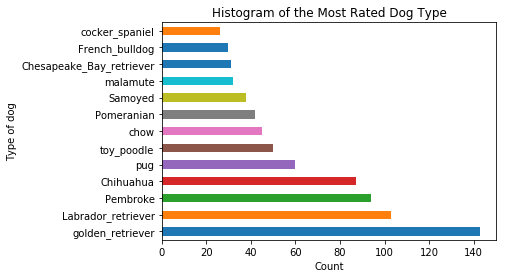

In [42]:
df_dog_type = df_twitter.groupby('dog_type').filter(lambda x: len(x) >= 25)

df_dog_type['dog_type'].value_counts().plot(kind = 'barh')
plt.title('Histogram of the Most Rated Dog Type')
plt.xlabel('Count')
plt.ylabel('Type of dog')

fig = plt.gcf() 
fig.savefig('output.png',bbox_inches='tight');

### Insight two
Japanese_spaniel has the lowest average rating Clumber has the highest average rating

In [43]:
df_dog_type_mean = df_twitter.groupby('dog_type').mean()

In [44]:
df_dog_type_mean.head()

,tweet_id,rating_numerator,rating_denominator,year,month,day,rating,favorite_count,retweet_count,followers_count,friends_count
dog_type,,,,,,,,,,,
Afghan_hound,8.095999e+17,8.000000,10.0,2016.500000,6.00,16.000000,8.000000,10775.500000,3011.500000,8.959824e+06,17.0
Airedale,7.184489e+17,9.833333,10.0,2015.583333,8.75,15.916667,9.833333,4671.750000,1177.250000,8.959850e+06,17.0
American_Staffordshire_terrier,7.597284e+17,10.312500,10.0,2016.187500,5.25,15.000000,10.312500,7480.533333,1738.333333,8.959839e+06,17.0
Appenzeller,7.939334e+17,11.000000,10.0,2016.500000,4.50,18.500000,11.000000,6502.000000,1211.000000,8.959833e+06,17.0
Australian_terrier,7.785921e+17,11.500000,10.0,2016.500000,3.50,7.000000,11.500000,9897.500000,2623.500000,8.959834e+06,17.0


In [45]:
df_dog_type_sorted = df_dog_type_mean['rating'].sort_values()

df_dog_type_sorted

dog_type
Japanese_spaniel                5.000000
Afghan_hound                    8.000000
soft-coated_wheaten_terrier     8.800000
Walker_hound                    9.000000
Scotch_terrier                  9.000000
Tibetan_terrier                 9.250000
dalmatian                       9.272727
Boston_bull                     9.416667
Saint_Bernard                   9.500000
Welsh_springer_spaniel          9.500000
Maltese_dog                     9.526316
Dandie_Dinmont                  9.571429
miniature_schnauzer             9.600000
Norwich_terrier                 9.600000
redbone                         9.666667
English_setter                  9.714286
Rhodesian_ridgeback             9.750000
Scottish_deerhound              9.750000
Irish_terrier                   9.800000
Great_Dane                      9.818182
Airedale                        9.833333
papillon                        9.833333
Mexican_hairless                9.857143
Newfoundland                    9.857143
miniatu

In [46]:
df_twitter[df_twitter['dog_type'] == 'golden_retriever']


,tweet_id,text,rating_numerator,rating_denominator,name,dogs_stage,year,month,day,rating,jpg_url,dog_type,confidence_list,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
8,667530908589760512,Meet Naphaniel. He doesn't necessarily enjoy h...,10,10,Naphaniel,None,2015,11,20,10.0,https://pbs.twimg.com/media/CUOL0uGUkAAx7yh.jpg,golden_retriever,0.633037,433.0,219.0,8959867.0,17.0,Twitter Web Client,Original tweet,https://t.co/xoRWyQTcmy
30,667044094246576128,12/10 gimme now https://t.co/QZAnwgnOMB,12,10,None,None,2015,11,18,12.0,https://pbs.twimg.com/media/CUHREBXXAAE6A9b.jpg,golden_retriever,0.765266,174.0,44.0,8959867.0,17.0,Twitter for iPhone,Original tweet,https://t.co/QZAnwgnOMB
37,667160273090932737,This is Bradlay. He is a Ronaldinho Matsuyama ...,11,10,Bradlay,None,2015,11,19,11.0,https://pbs.twimg.com/media/CUI6uuaW4AAvCIs.jpg,golden_retriever,0.471351,234.0,55.0,8959867.0,17.0,Twitter for iPhone,Original tweet,https://t.co/DKhgkMx4N1
43,667182792070062081,This is Timison. He just told an awful joke bu...,10,10,Timison,None,2015,11,19,10.0,https://pbs.twimg.com/media/CUJPNjOWsAAZRqP.jpg,golden_retriever,0.949892,13176.0,5591.0,8959867.0,17.0,Twitter for iPhone,Original tweet,https://t.co/s2yYuHabWl
46,667211855547486208,This is Genevieve. She is a golden retriever c...,9,10,Genevieve,None,2015,11,19,9.0,https://pbs.twimg.com/media/CUJppKJWoAA75NP.jpg,golden_retriever,0.462556,448.0,220.0,8959867.0,17.0,Twitter for iPhone,Original tweet,https://t.co/azEoGqVonH
62,668286279830867968,Meet Rusty. Rusty's dreaming of a world where ...,11,10,Rusty,None,2015,11,22,11.0,https://pbs.twimg.com/media/CUY60usWoAAdBxx.jpg,golden_retriever,0.215944,469.0,126.0,8959868.0,17.0,Twitter for iPhone,Original tweet,https://t.co/C8U6cxI1Jc
76,666345417576210432,Look at this jokester thinking seat belt laws ...,10,10,None,None,2015,11,16,10.0,https://pbs.twimg.com/media/CT9Vn7PWoAA_ZCM.jpg,golden_retriever,0.858744,265.0,128.0,8959867.0,17.0,Twitter for iPhone,Original tweet,https://t.co/VFKG1vxGjB
78,666063827256086533,This is the happiest dog you will ever see. Ve...,10,10,the,None,2015,11,16,10.0,https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg,golden_retriever,0.77593,433.0,190.0,8959867.0,17.0,Twitter for iPhone,Original tweet,https://t.co/RhUEAloehK
94,666057090499244032,My oh my. This is a rare blond Canadian terrie...,9,10,a,None,2015,11,16,9.0,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,golden_retriever,0.00795896,262.0,118.0,8959867.0,17.0,Twitter for iPhone,Original tweet,https://t.co/yWBqbrzy8O
110,876484053909872640,This is Benedict. He wants to thank you for th...,13,10,Benedict,None,2017,6,18,13.0,https://pbs.twimg.com/media/DCnll_dUQAAkBdG.jpg,golden_retriever,0.874566,17184.0,2087.0,8959819.0,17.0,Twitter for iPhone,Original tweet,https://t.co/ccBFQU5UWO


### Insight three & visualization

Dog_types with low number of ratings show a high variaty of mean ratings.

In [47]:
df_dog_type_count = df_twitter.groupby('dog_type').count()
df_dog_type_count

,tweet_id,text,rating_numerator,rating_denominator,name,dogs_stage,year,month,day,rating,jpg_url,confidence_list,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
dog_type,,,,,,,,,,,,,,,,,,,
Afghan_hound,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Airedale,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12
American_Staffordshire_terrier,16,16,16,16,16,16,16,16,16,16,16,16,15,15,15,15,15,15,15
Appenzeller,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Australian_terrier,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Bedlington_terrier,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
Bernese_mountain_dog,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
Blenheim_spaniel,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
Border_collie,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12


In [40]:
dog_type_count = df_dog_type_count['rating']
dog_type_mean = df_dog_type_mean['rating']
dog_type_mean

dog_type
Afghan_hound                       8.000000
Airedale                           9.833333
American_Staffordshire_terrier    10.312500
Appenzeller                       11.000000
Australian_terrier                11.500000
                                    ...    
toy_poodle                        11.020000
toy_terrier                       10.333333
vizsla                            10.846154
whippet                           10.181818
wire-haired_fox_terrier           11.500000
Name: rating, Length: 113, dtype: float64

In [41]:
df = pd.DataFrame()
df['dog_type_count'] = dog_type_count
df['dog_type_mean'] = dog_type_mean
df

,dog_type_count,dog_type_mean
dog_type,,
Afghan_hound,2,8.000000
Airedale,12,9.833333
American_Staffordshire_terrier,16,10.312500
Appenzeller,2,11.000000
Australian_terrier,2,11.500000
...,...,...
toy_poodle,50,11.020000
toy_terrier,3,10.333333
vizsla,13,10.846154


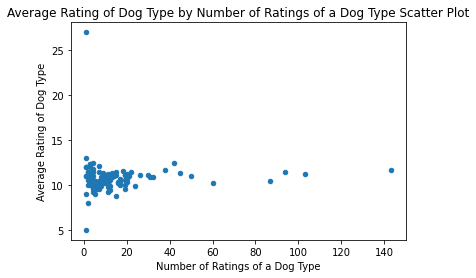

In [42]:
df.plot(x='dog_type_count', y='dog_type_mean', kind='scatter')
plt.xlabel('Number of Ratings of a Dog Type')
plt.ylabel('Average Rating of Dog Type')
plt.title('Average Rating of Dog Type by Number of Ratings of a Dog Type Scatter Plot')

fig = plt.gcf()
#plt.savefig('X:/' + newName + '.png', 
fig.savefig('output2.png',bbox_inches='tight');

### Insight four & visualization

The highest ratings do not receive the most retweets.


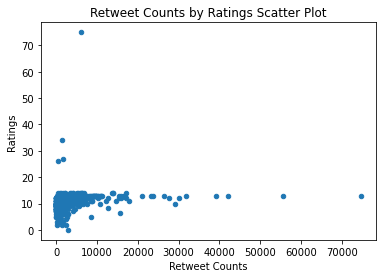

In [43]:
df_twitter.plot(x='retweet_count', y='rating', kind='scatter')
plt.xlabel('Retweet Counts')
plt.ylabel('Ratings')
plt.title('Retweet Counts by Ratings Scatter Plot')

fig = plt.gcf()
fig.savefig('output3.png',bbox_inches='tight');